In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
!pip install PyWavelets

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.5/4.5 MB 34.3 MB/s eta 0:00:00


In [3]:
import os

# Path where training data is stored
train_data_path = "/content/drive/MyDrive/Dataset/splitset/"

# Get participant IDs from existing training files
train_participants = [
    file.split("_")[0] for file in os.listdir(train_data_path) if file.endswith("_train.mat")
]
train_participants = sorted(set(map(int, train_participants)))  # Ensure unique and sorted IDs

print("Loaded train participants:", train_participants)

Loaded train participants: [1, 2, 3, 6, 8, 10, 11, 12, 14, 15, 16, 17, 18, 19, 21, 22, 23, 24, 29, 30, 31, 32, 33, 35, 36, 37, 39, 42, 43, 45, 46, 47, 48]


In [4]:
import numpy as np
import scipy.io
import pywt
import matplotlib.pyplot as plt
import joblib

sampling_rate = 256
selected_channels = [3, 5, 8, 14, 17, 19, 24, 25, 36, 39, 40, 45, 47, 52, 53]
selected_channels = [ch - 1 for ch in selected_channels]  # Convert to 0-based indexing

# Adjusted frequency bands (0.5-20Hz filter)
theta_band = (4, 8)    # theta band limited by upper cutoff
full_band = (0.5, 20)   # Effective frequency range

# Function to compute power using CWT
def compute_power_cwt(signal, scales, wavelet):
    coefficients, _ = pywt.cwt(signal, scales, wavelet, sampling_period=1.0/sampling_rate)
    return np.abs(coefficients) ** 2  # Power

# Initialize list to store relative theta power features
all_relative_theta_power = []

# Wavelet parameters - using narrower bandwidth for better frequency resolution
wavelet = 'cmor1.0-1.5'  # Complex Morlet wavelet optimized for limited bandwidth

# Loop through each participant
for participant in train_participants:
    # Load the .mat file
    train_file_path = f'/content/drive/MyDrive/Dataset/splitset/{int(participant)}_train.mat'
    data = scipy.io.loadmat(train_file_path)
    participant_data = data['train_data']  # Shape: (timepoints, channels, trials)

    # Segment parameters
    trial_duration = 1.5  # seconds
    segment_duration = 20  # seconds
    trials_per_segment = int(segment_duration / trial_duration)

    # Window parameters
    window_duration = 5  # seconds
    window_length = window_duration * sampling_rate
    overlap = 0.5  # 50% overlap
    step_size = int(window_length * (1 - overlap))

    for start in range(0, participant_data.shape[2] - trials_per_segment + 1, trials_per_segment):
        # Extract segment
        segment = participant_data[:, selected_channels, start:start+trials_per_segment]
        segment = segment.reshape(-1, len(selected_channels))[:20*sampling_rate, :]

        # Process each window
        for i in range(0, len(segment) - window_length + 1, step_size):
            window = segment[i:i+window_length, :]
            window_features = []

            for ch in range(len(selected_channels)):
                # Compute total power (within effective band)
                scales_full = pywt.frequency2scale(wavelet, np.array(full_band)/sampling_rate)
                total_power = compute_power_cwt(window[:, ch], scales_full, wavelet).sum()

                # Compute theta power (limited to 13-20Hz)
                scales_theta = pywt.frequency2scale(wavelet, np.array(theta_band)/sampling_rate)
                theta_power = compute_power_cwt(window[:, ch], scales_theta, wavelet).sum()

                # Calculate relative theta power (with protection against division by zero)
                relative_theta = theta_power / total_power if total_power > 0 else 0
                window_features.append(relative_theta)

            # Average across channels
            all_relative_theta_power.append(np.mean(window_features))

# Convert to numpy array and reshape for clustering
X = np.array(all_relative_theta_power).reshape(-1, 1)



In [5]:
from sklearn.preprocessing import StandardScaler
import joblib

# Normalize the features
scaler = StandardScaler()
normalized_features = scaler.fit_transform(X)

# Save the scaler for later use
scaler_path = "/content/drive/MyDrive/Dataset/clustering_models/DBSCAN_RTP_Scaler.pkl"
joblib.dump(scaler, scaler_path)
print(f"Scaler saved to {scaler_path}")

Scaler saved to /content/drive/MyDrive/Dataset/clustering_models/DBSCAN_RTP_Scaler.pkl


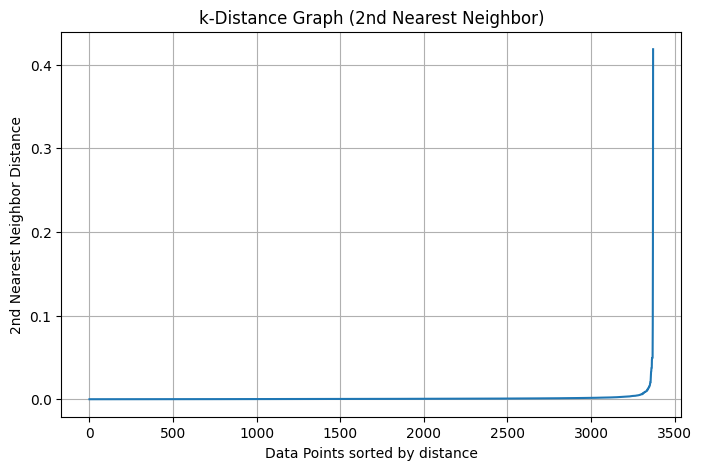

In [6]:
from sklearn.neighbors import NearestNeighbors
import numpy as np
import matplotlib.pyplot as plt

neighbors = NearestNeighbors(n_neighbors=2)
neighbors_fit = neighbors.fit(normalized_features)
distances, indices = neighbors_fit.kneighbors(normalized_features)

# Sort the distances to see the 'elbow'
sorted_distances = np.sort(distances[:, 1])
plt.figure(figsize=(8, 5))
plt.plot(sorted_distances)
plt.title('k-Distance Graph (2nd Nearest Neighbor)')
plt.xlabel('Data Points sorted by distance')
plt.ylabel('2nd Nearest Neighbor Distance')
plt.grid(True)
plt.show()


The elbow appears around a 2nd nearest neighbor distance of approximately 0.03.

In [7]:
from sklearn.cluster import DBSCAN
from sklearn.metrics import silhouette_score, davies_bouldin_score
import numpy as np

# Use eps from elbow point
eps = 0.03
min_samples = 2

# Apply DBSCAN
dbscan = DBSCAN(eps=eps, min_samples=min_samples)
labels = dbscan.fit_predict(normalized_features)

# Check for valid clustering (more than 1 cluster and not all noise)
if len(set(labels)) > 1 and not (len(set(labels)) == 1 + (1 if -1 in labels else 0)):
    sil_score = silhouette_score(normalized_features, labels)
    dbi_score = davies_bouldin_score(normalized_features, labels)
    print(f"Silhouette Score: {sil_score:.4f}")
    print(f"Davies-Bouldin Index: {dbi_score:.4f}")
else:
    sil_score = dbi_score = float('nan')
    print("Not enough clusters to compute Silhouette or DBI (all noise or one cluster).")


Silhouette Score: 0.2108
Davies-Bouldin Index: 7.6595


<ipython-input-8-b54b2c12774d>:8: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  colors = plt.cm.get_cmap('tab10', len(unique_labels))


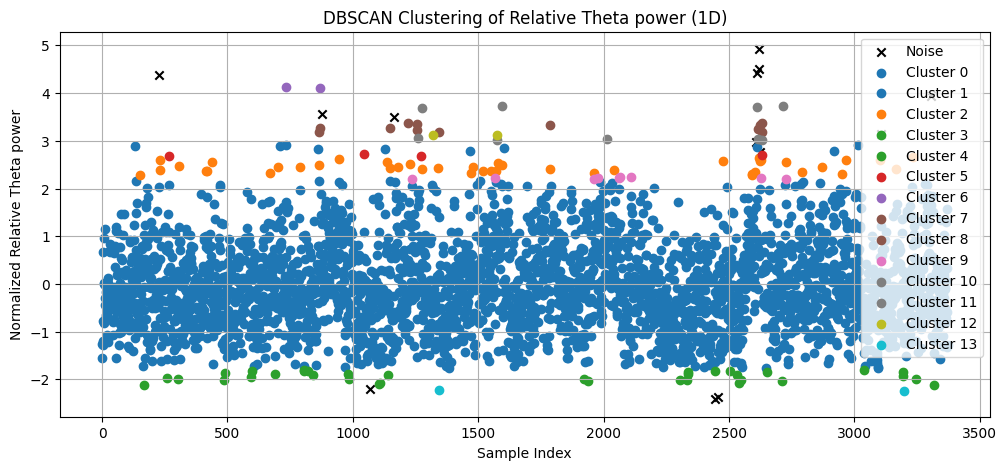

In [8]:
import matplotlib.pyplot as plt

# Create x-axis for plotting
x = np.arange(len(normalized_features))

plt.figure(figsize=(12, 5))
unique_labels = sorted(set(labels))
colors = plt.cm.get_cmap('tab10', len(unique_labels))

for label in unique_labels:
    cluster_mask = labels == label
    if label == -1:
        plt.scatter(x[cluster_mask], normalized_features[cluster_mask],
                    color='k', marker='x', label='Noise')
    else:
        plt.scatter(x[cluster_mask], normalized_features[cluster_mask],
                    color=colors(label), label=f'Cluster {label}')

plt.title('DBSCAN Clustering of Relative Theta power (1D)')
plt.xlabel('Sample Index')
plt.ylabel('Normalized Relative Theta power')
plt.legend()
plt.grid(True)
plt.show()
